<a href="https://colab.research.google.com/github/pzwiernik/22997-networks/blob/main/colabs/NetworkNotebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Notebook 3 — Erdős-Rényi Random Graphs

This notebook accompanies **Lectures 7 and 8**. It introduces the classical random network model $G(N,p)$ and explores its fundamental properties.

By working through this notebook, you should:
- understand how to simulate $G(N,p)$ networks in Python (using NetworkX);
- explore empirical and theoretical degree distributions;
- observe concentration phenomena (Chebyshev, Hoeffding);
- visualize asymptotic regimes: sparse vs dense networks;
- identify the **giant component** and **connectivity thresholds** discussed in Lecture 8.

You can modify the code and parameters as you go — most cells run in under 10 seconds.

# Section 1 — Simulating the Erdős-Rényi model

We introduced the *Erdős-Rényi model* $G(N,p)$, where each possible edge between $N$ nodes is included independently with probability $p$.

The key idea: randomness enters *only through edges*. Changing $p$ controls the overall network density. Feel free to play with different values of $p$ below.

Nodes: 200, Edges: 290, Expected degree: 2.985


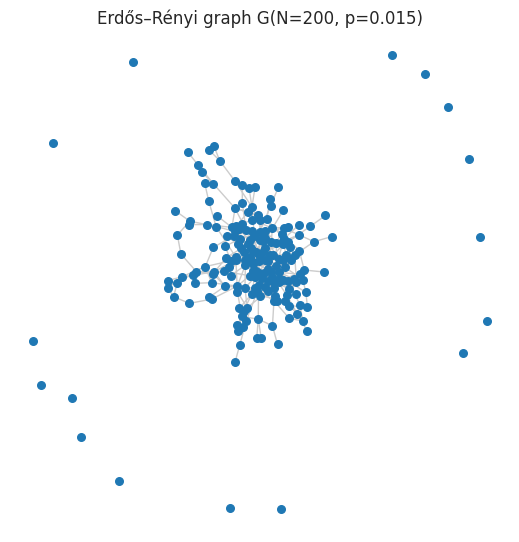

In [24]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # prettier visualization
sns.set_style("whitegrid")

N = 200
p = 0.015

G = nx.erdos_renyi_graph(N, p)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}, Expected degree: {(N-1)*p}")

pos = nx.spring_layout(G, seed=5)
plt.figure(figsize=(5,5))
nx.draw(G, pos, node_size=30, edge_color="#cccccc")
plt.title(f"Erdős–Rényi graph G(N={N}, p={p})")
plt.show()

# Section 2 — Degree distribution

Each vertex degree follows a **Binomial** distribution  
$$\deg(v)\sim \text{Bin}(N-1, p),
\quad \mathbb E[\deg(v)] = (N-1)p.$$

For small $p$ and large $N$, this becomes approximately **Poisson(λ)**, where $λ=(N-1)p$.  
Try experimenting with different values of $p$ to see this transition.

Empirical mean degree: 2.9
Theoretical mean degree: 2.985


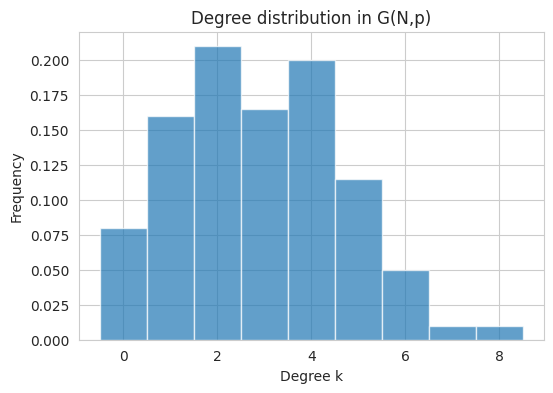

In [25]:
deg = np.array([d for _, d in G.degree()])
print("Empirical mean degree:", deg.mean())
print("Theoretical mean degree:", (N-1)*p)

plt.figure(figsize=(6,4))
bins = np.arange(deg.max()+2)-0.5
plt.hist(deg, bins=bins, density=True, alpha=0.7)
plt.xlabel("Degree k")
plt.ylabel("Frequency")
plt.title("Degree distribution in G(N,p)")
plt.show()

# Section 3 — Poisson approximation

When $p=\frac{\lambda}{N}$, the Binomial law converges to ${\rm Poisson}(\lambda)$.  
This defines the **sparse regime**, often used as a realistic model for large networks.

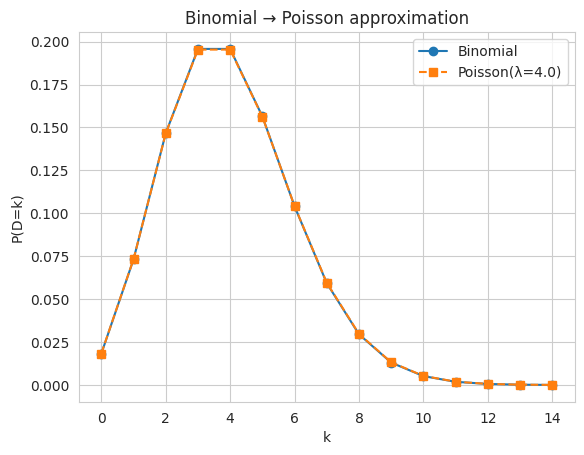

In [30]:
from scipy.stats import poisson, binom

N = 1000 # big N
p = 0.004 #small p
lam = N*p
k_vals = np.arange(0, 15)

plt.plot(k_vals, binom.pmf(k_vals, N-1, p), 'o-', label="Binomial")
plt.plot(k_vals, poisson.pmf(k_vals, lam), 's--', label=f"Poisson(λ={lam:.1f})")
plt.xlabel("k")
plt.ylabel("P(D=k)")
plt.title("Binomial → Poisson approximation")
plt.legend()
plt.show()

# Section 4 — Concentration of degree

By Hoeffding’s inequality, degrees are tightly concentrated around their mean:  
$$
\Pr(|\deg(v)-(N-1)p|\ge t)\le 2e^{-2t^2/(N-1)}.
$$

This shows that even though edges are random, degrees fluctuate very little when $N$ is large.

In [32]:
def hoeffding_bound(t, n, p):
    return 2*np.exp(-2*t**2/n)

N = 1000
p = 0.1
t = 40
edeg = (N-1)*p # expected degree
prob = hoeffding_bound(t, N-1, p)
print(f"P(|deg(v)-{edeg:.3g}| ≥ {t}) ≤ {prob:.3g}")

P(|deg(v)-99.9| ≥ 40) ≤ 0.0813


# Section 5 — Dense vs sparse scaling

When $p$ is "constant", the average degree grows with $N$: the graph becomes *dense*.  

When $p = \lambda/N$, the average degree stays bounded: *sparse regime*.  

Most real-world networks lie somewhere in between.

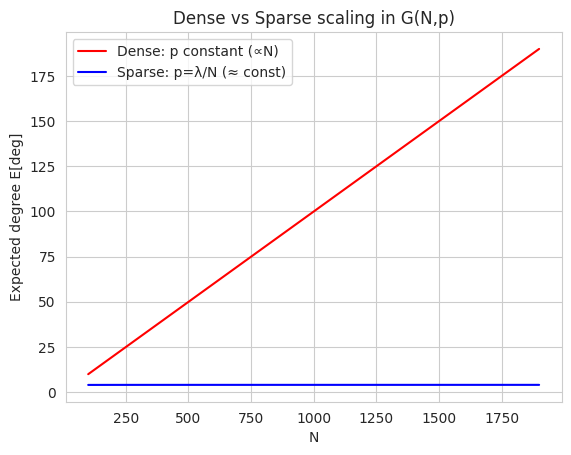

In [35]:
N_list = np.arange(100, 2000, 100) # create a list 100,200,300,...,2000
p_dense = 0.1
p_sparse = 4 / N_list
deg_dense = [(N-1)*p_dense for N in N_list]
deg_sparse = [(N-1)*p_sparse[i] for i, N in enumerate(N_list)]

plt.plot(N_list, deg_dense, 'r-', label="Dense: p constant (∝N)")
plt.plot(N_list, deg_sparse, 'b-', label="Sparse: p=λ/N (≈ const)")
plt.xlabel("N")
plt.ylabel("Expected degree E[deg]")
plt.title("Dense vs Sparse scaling in G(N,p)")
plt.legend()
plt.show()

# Section 6 — Giant component threshold

As $p$ increases, a single **giant component** suddenly emerges near $p\approx 1/N$ (or equivalently when the average degree $c=Np \approx 1$).

Below this value, all components are tiny; above it, most nodes belong to the same connected block.

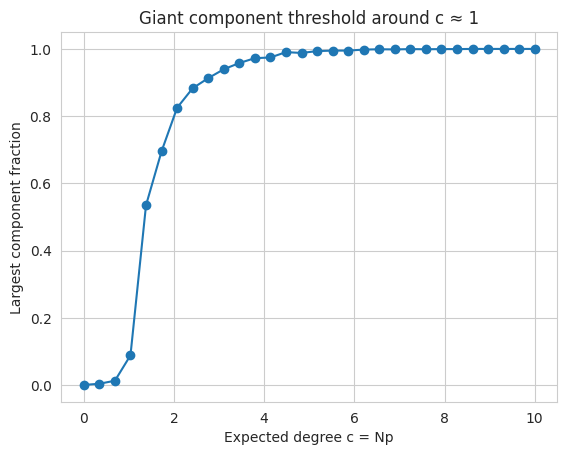

In [38]:
def largest_component_fraction(N, p):
    G = nx.erdos_renyi_graph(N, p)
    components = list(nx.connected_components(G))
    largest = max(components, key=len)
    return len(largest)/N

N = 2000
p_values = np.linspace(0, 0.005, 30) # 30 values equally spaced between 0 and 0.005
fractions = [largest_component_fraction(N, p) for p in p_values]

plt.plot(p_values*N, fractions, 'o-')
plt.xlabel("Expected degree c = Np")
plt.ylabel("Largest component fraction")
plt.title("Giant component threshold around c ≈ 1")
plt.show()

# Section 7 — Connectivity threshold

Connectivity appears later, when $p$ exceeds $(\log N)/N$.  
At that point, isolated vertices disappear with high probability and the entire network becomes connected.

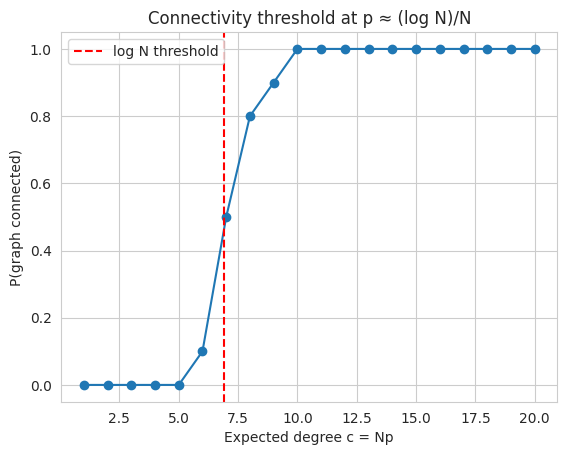

In [41]:
def is_connected(N, p, trials=10):
    return np.mean([nx.is_connected(nx.erdos_renyi_graph(N, p)) for _ in range(trials)])

N = 1000
p_vals = np.linspace(0.001, 0.02, 20)
conn_prob = [is_connected(N, p) for p in p_vals]

plt.plot(p_vals*N, conn_prob, 'o-')
plt.axvline(np.log(N), color='r', linestyle='--', label='log N threshold')
plt.xlabel("Expected degree c = Np")
plt.ylabel("P(graph connected)")
plt.title("Connectivity threshold at p ≈ (log N)/N")
plt.legend()
plt.show()

# Summary

### Summary (Lectures 7–8)
- **Model:** $G(N,p)$ — each edge appears independently with probability $p$.
- **Degree distribution:** Binomial → Poisson(λ) when $p=λ/N$.
- **Concentration:** Degrees sharply cluster around their mean.
- **Giant component:** Appears near $p\approx 1/N$.
- **Connectivity:** Reached near $p\approx (\log N)/N$.

### Optional exploration
- Repeat simulations for different $N$ (e.g., 100, 1000, 5000).
- Compare empirical degree histograms to the Poisson prediction.
- Observe how connectivity and the giant component thresholds move with $N$.